# Software Analytics 101
## An Interactive Hands-on Tutorial on Mining, Analyzing, Modelling, and Explaining Software Data
by Dr. Chakkrit (Kla) Tantithamthavorn, Monash University, Melbourne, Australia.

# About this tutorial
Software analytics focuses on analyzing and modeling a rich source of software data using well-established data analytics techniques in order to glean actionable insights for improving development practices, productivity, and software quality. However, if care is not taken when analyzing and modeling software data, the predictions and insights that are derived from analytical models may be inaccurate and unreliable. The goal of this hands-on tutorial is to guide participants on how to (1) analyze software data using statistical techniques like correlation analysis, hypothesis testing, effect size analysis, and multiple comparisons, (2) develop accurate, reliable, and reproducible analytical models, (3) interpret the models to uncover relationships and insights, and (4) discuss pitfalls associated with analytical techniques including hands-on examples with real software data. R will be the primary programming language. Code samples will be available in a public GitHub repository. Participants will do exercises via RStudio.

## Outline

* [Part I: Mining Software Data](#mining)
* [Part II: Analyzing Software Data](#analyzing)
* [Part III: Modelling Software Data](#modelling)
* [Part IV: Explaining Software Data](#explaining)

# Part I: Mining Software Data <a class="anchor" id="mining"></a>

This part is in progress. The content will be available soon.

# Part II: Analyzing Software Data <a class="anchor" id="mining"></a>

###### Let's suppress all warning

In [18]:
options(warn=-1)

###### Install necessary R packages for this tutorial

In [19]:
library(Rnalytica)
library(ggplot2)
library(car)
library(effects)
library(ScottKnottESD)
library(gridExtra)
library(effsize)
library(dplyr)
library(rms)
library(Rnalytica)
library(C50)
library(randomForest)
library(FFTrees)
library(gridExtra)
library(caret)
library(DMwR)

###### Load an example defect dataset

In [20]:
eclipse <- loadDefectDataset("eclipse-2.0")
data <- eclipse$data
indep <- eclipse$indep
dep <- eclipse$dep
data[,dep] <- factor(data[,dep])

###### Understand your data

In [21]:
str(data[,indep])

'data.frame':	6729 obs. of  32 variables:
 $ pre     : num  1 1 0 2 2 1 0 0 1 2 ...
 $ ACD     : num  0 0 0 0 4 0 0 0 0 0 ...
 $ FOUT_avg: num  6.75 12.5 5.33 7.33 6.21 ...
 $ FOUT_max: num  29 13 10 16 27 1 4 0 0 22 ...
 $ FOUT_sum: num  54 25 16 88 118 2 8 0 0 168 ...
 $ MLOC_avg: num  9.25 16 12.67 9.67 9.89 ...
 $ MLOC_max: num  32 18 29 28 55 8 12 0 0 32 ...
 $ MLOC_sum: num  74 32 38 116 188 10 22 0 0 280 ...
 $ NBD_avg : num  1.75 2 3 2.08 1.79 ...
 $ NBD_max : num  5 3 6 5 4 1 2 0 0 6 ...
 $ NBD_sum : num  14 4 9 25 34 2 7 0 0 57 ...
 $ NOF_avg : num  0 0 0 0 8 ...
 $ NOF_max : num  0 0 0 0 8 0 2 0 0 11 ...
 $ NOF_sum : num  0 0 0 0 8 0 2 0 0 13 ...
 $ NOI     : num  0 0 0 0 0 0 0 1 0 0 ...
 $ NOM_avg : num  8 2 3 12 18 ...
 $ NOM_max : num  8 2 3 12 18 2 3 9 0 29 ...
 $ NOM_sum : num  8 2 3 12 18 2 6 9 0 32 ...
 $ NOT     : num  1 1 1 1 1 1 1 0 1 1 ...
 $ NSF_avg : num  3 1 0 0 0 ...
 $ NSF_max : num  3 1 0 0 0 0 0 3 16 1 ...
 $ NSF_sum : num  3 1 0 0 0 0 0 3 16 1 ...
 $ NSM_a

###### Understand the defective ratio

In [22]:
table(data[,dep])/nrow(data)


    FALSE      TRUE 
0.8551048 0.1448952 

# INTRO: BASIC REGRESSION ANALYSIS

##### Building a logistic regression model

In [23]:
m <- glm(post ~ CC_max, data = data, family="binomial")

##### Let's take a look how a model looks like

In [24]:
summary(m)


Call:
glm(formula = post ~ CC_max, family = "binomial", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.6213  -0.5113  -0.4410  -0.3991   2.2671  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.490129   0.051777  -48.09   <2e-16 ***
CC_max       0.104319   0.004819   21.65   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5568.3  on 6728  degrees of freedom
Residual deviance: 4967.3  on 6727  degrees of freedom
AIC: 4971.3

Number of Fisher Scoring iterations: 5


##### What about the model visualization?

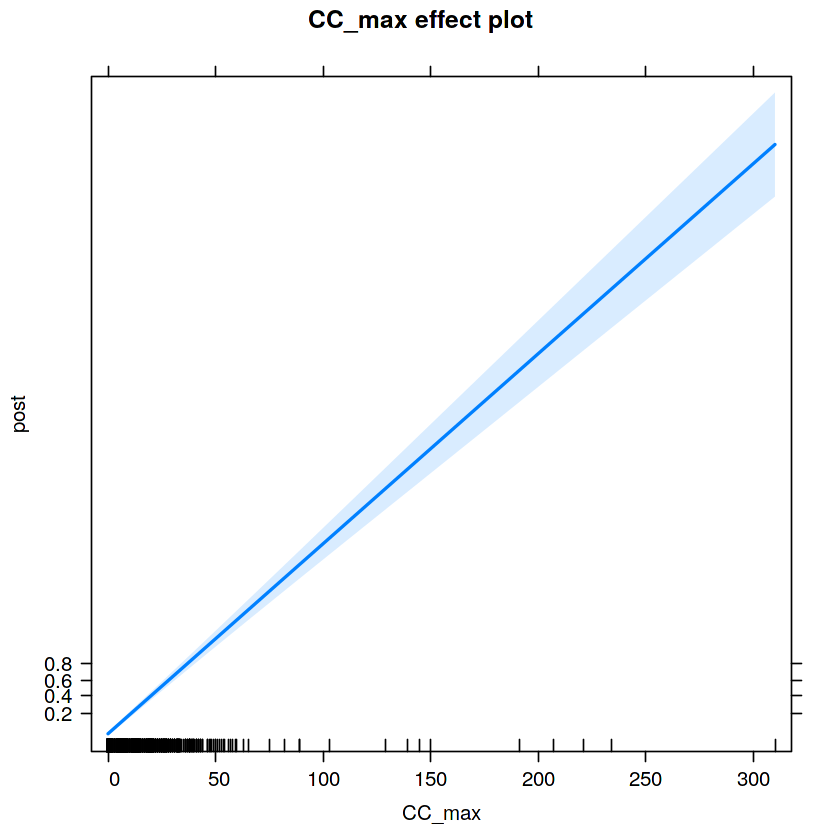

In [25]:
plot(allEffects(m))

# INTRO: PRELIMINARY DATA ANALYSIS

##### Check data distribution

In [26]:
summary(data$CC_sum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     2.0    10.0    26.9    28.0  1299.0 

##### Hypothesis Testing (CC)

In [27]:
wilcox.test(data[data$post==TRUE,]$CC_sum, data[data$post==FALSE,]$CC_sum)


	Wilcoxon rank sum test with continuity correction

data:  data[data$post == TRUE, ]$CC_sum and data[data$post == FALSE, ]$CC_sum
W = 4380955, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


##### Let's take a look at the data distribution

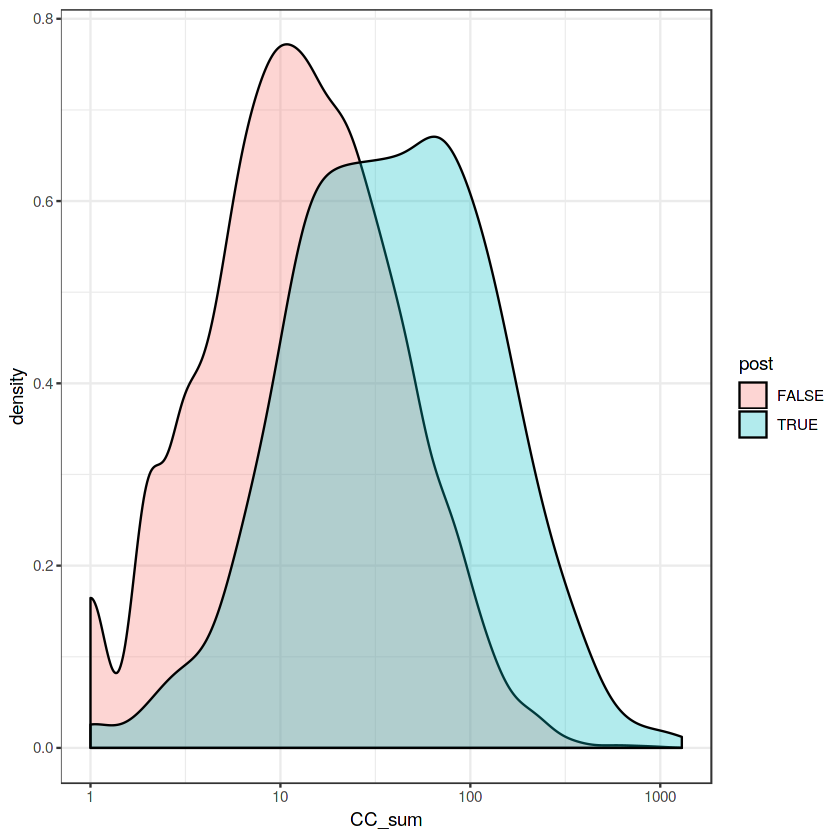

In [28]:
ggplot(data, aes(x=CC_sum, fill=post)) + geom_density(alpha=.3) + scale_x_log10() + theme_bw()

###### Test Alternative Hypotheses

In [29]:
wilcox.test(data[data$post==TRUE,]$CC_sum, data[data$post==FALSE,]$CC_sum, alternative = "greater")
wilcox.test(data[data$post==TRUE,]$CC_sum, data[data$post==FALSE,]$CC_sum, alternative = "less")


	Wilcoxon rank sum test with continuity correction

data:  data[data$post == TRUE, ]$CC_sum and data[data$post == FALSE, ]$CC_sum
W = 4380955, p-value < 2.2e-16
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  data[data$post == TRUE, ]$CC_sum and data[data$post == FALSE, ]$CC_sum
W = 4380955, p-value = 1
alternative hypothesis: true location shift is less than 0


##### Cliff's delta effect size

In [31]:
cliff.delta(data[data$post==TRUE,]$CC_sum, data[data$post==FALSE,]$CC_sum)


Cliff's Delta

delta estimate: 0.561796 (large)
95 percent confidence interval:
    lower     upper 
0.5304041 0.5916494 